<a href="https://colab.research.google.com/github/SmitMhatre2004/Credit-Card-Fraud-Detection/blob/main/credit_card_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install imbalanced-learn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
import warnings
warnings.filterwarnings('ignore')

In [ ]:
plt.style.use('default')
sns.set_palette("husl")

In [ ]:
class CreditCardFraudDetector:
    def __init__(self):
        self.scaler = StandardScaler()
        self.model = LogisticRegression(random_state=42, max_iter=1000, solver='liblinear')
        self.is_trained = False
        self.feature_names = None

    def load_and_explore_data(self, file_path):
        """Load and explore the credit card dataset"""
        print(" LOADING AND EXPLORING DATASET")
        print("=" * 50)


        try:
            df = pd.read_csv(file_path)
            print(f" Dataset loaded successfully!")
        except Exception as e:
            print(f" Error loading dataset: {e}")
            return None

        print(f" Dataset shape: {df.shape}")
        print(f"  Columns: {list(df.columns)}")


        missing_values = df.isnull().sum().sum()
        print(f" Missing values: {missing_values}")


        class_counts = df['Class'].value_counts()
        fraud_percentage = (class_counts[1] / len(df)) * 100

        print(f"\nCLASS DISTRIBUTION:")
        print(f"   Normal transactions: {class_counts[0]:,} ({100-fraud_percentage:.3f}%)")
        print(f"   Fraud transactions:  {class_counts[1]:,} ({fraud_percentage:.3f}%)")


        print(f"\n TRANSACTION AMOUNT STATISTICS:")
        amount_stats = df.groupby('Class')['Amount'].describe()
        print(amount_stats)


        print(f"\n TIME ANALYSIS:")
        time_stats = df.groupby('Class')['Time'].describe()
        print(time_stats)

        return df

    def visualize_data(self, df):
        """Create comprehensive visualizations of the dataset"""
        print("\n CREATING VISUALIZATIONS...")


        fig, axes = plt.subplots(2, 3, figsize=(20, 12))
        fig.suptitle('Credit Card Fraud Detection - Data Analysis', fontsize=16, fontweight='bold')


        class_counts = df['Class'].value_counts()
        colors = ['#3498db', '#e74c3c']
        axes[0,0].pie(class_counts.values, labels=['Normal', 'Fraud'], autopct='%1.3f%%',
                      colors=colors, startangle=90)
        axes[0,0].set_title('Class Distribution', fontweight='bold')


        axes[0,1].hist(df[df['Class'] == 0]['Amount'], bins=50, alpha=0.7,
                       label='Normal', color='#3498db', density=True)
        axes[0,1].hist(df[df['Class'] == 1]['Amount'], bins=50, alpha=0.7,
                       label='Fraud', color='#e74c3c', density=True)
        axes[0,1].set_xlabel('Transaction Amount')
        axes[0,1].set_ylabel('Density')
        axes[0,1].set_title('Transaction Amount Distribution', fontweight='bold')
        axes[0,1].legend()
        axes[0,1].set_xlim(0, 1000)


        df['Time_hours'] = df['Time'] / 3600
        axes[0,2].hist(df[df['Class'] == 0]['Time_hours'], bins=48, alpha=0.7,
                       label='Normal', color='#3498db', density=True)
        axes[0,2].hist(df[df['Class'] == 1]['Time_hours'], bins=48, alpha=0.7,
                       label='Fraud', color='#e74c3c', density=True)
        axes[0,2].set_xlabel('Time (hours)')
        axes[0,2].set_ylabel('Density')
        axes[0,2].set_title('Transaction Time Distribution', fontweight='bold')
        axes[0,2].legend()


        df_plot = df[df['Amount'] <= 1000]
        sns.boxplot(data=df_plot, x='Class', y='Amount', ax=axes[1,0])
        axes[1,0].set_title('Amount Distribution by Class (Filtered)', fontweight='bold')
        axes[1,0].set_xlabel('Class (0=Normal, 1=Fraud)')


        v_features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10']
        corr_matrix = df[v_features + ['Class']].corr()
        sns.heatmap(corr_matrix, annot=True, cmap='RdYlBu_r', center=0,
                    fmt='.2f', ax=axes[1,1])
        axes[1,1].set_title('Feature Correlation Matrix (V1-V10)', fontweight='bold')


        v_features_variance = []
        for feature in ['V1', 'V2', 'V3', 'V4', 'V5']:
            normal_var = df[df['Class'] == 0][feature].var()
            fraud_var = df[df['Class'] == 1][feature].var()
            v_features_variance.append({'Feature': feature, 'Normal_Var': normal_var, 'Fraud_Var': fraud_var})

        var_df = pd.DataFrame(v_features_variance)
        x = np.arange(len(var_df))
        width = 0.35
        axes[1,2].bar(x - width/2, var_df['Normal_Var'], width, label='Normal', color='#3498db')
        axes[1,2].bar(x + width/2, var_df['Fraud_Var'], width, label='Fraud', color='#e74c3c')
        axes[1,2].set_xlabel('Features')
        axes[1,2].set_ylabel('Variance')
        axes[1,2].set_title('Feature Variance by Class (V1-V5)', fontweight='bold')
        axes[1,2].set_xticks(x)
        axes[1,2].set_xticklabels(var_df['Feature'])
        axes[1,2].legend()

        plt.tight_layout()
        plt.show()

        return df

    def handle_class_imbalance(self, X, y, method='smote'):
        """Handle class imbalance using various techniques"""
        print(f"\n  HANDLING CLASS IMBALANCE")
        print("=" * 30)

        original_counts = np.bincount(y)
        print(f"Original distribution: Normal={original_counts[0]:,}, Fraud={original_counts[1]:,}")

        if method == 'smote':
            print(" Applying SMOTE (Synthetic Minority Oversampling)...")
            sampler = SMOTE(random_state=42, sampling_strategy=0.1)

        elif method == 'undersample':
            print(" Applying Random Undersampling...")
            sampler = RandomUnderSampler(random_state=42, sampling_strategy=0.5)

        elif method == 'smoteenn':
            print(" Applying SMOTE + Edited Nearest Neighbours...")
            sampler = SMOTEENN(random_state=42)

        X_resampled, y_resampled = sampler.fit_resample(X, y)

        new_counts = np.bincount(y_resampled)
        print(f"New distribution: Normal={new_counts[0]:,}, Fraud={new_counts[1]:,}")
        print(f"Fraud ratio: {new_counts[1]/(new_counts[0]+new_counts[1]):.3f}")

        return X_resampled, y_resampled

    def train_model(self, X_train, y_train):
        """Train the logistic regression model"""
        print(f"\n TRAINING LOGISTIC REGRESSION MODEL")
        print("=" * 40)


        self.feature_names = X_train.columns.tolist()


        print(" Scaling features...")
        X_train_scaled = self.scaler.fit_transform(X_train)


        print(" Training model...")
        self.model.fit(X_train_scaled, y_train)
        self.is_trained = True


        feature_importance = pd.DataFrame({
            'feature': self.feature_names,
            'coefficient': self.model.coef_[0],
            'abs_coefficient': np.abs(self.model.coef_[0])
        }).sort_values('abs_coefficient', ascending=False)

        print("\n🏆 TOP 15 MOST IMPORTANT FEATURES:")
        print(feature_importance.head(15)[['feature', 'coefficient']].to_string(index=False))


        train_accuracy = self.model.score(X_train_scaled, y_train)
        print(f"\n Training accuracy: {train_accuracy:.4f}")

        return X_train_scaled, feature_importance

    def evaluate_model(self, X_test, y_test):
        """Comprehensive model evaluation"""
        print(f"\n MODEL EVALUATION")
        print("=" * 25)

        if not self.is_trained:
            raise Exception(" Model must be trained first!")

        X_test_scaled = self.scaler.transform(X_test)


        y_pred = self.model.predict(X_test_scaled)
        y_pred_proba = self.model.predict_proba(X_test_scaled)[:, 1]


        roc_auc = roc_auc_score(y_test, y_pred_proba)
        avg_precision = average_precision_score(y_test, y_pred_proba)

        print(f" ROC-AUC Score: {roc_auc:.4f}")
        print(f" Average Precision Score: {avg_precision:.4f}")


        print(f"\n CLASSIFICATION REPORT:")
        print(classification_report(y_test, y_pred))


        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()

        print(f"\n CONFUSION MATRIX ANALYSIS:")
        print(f"True Negatives:  {tn:,}")
        print(f"False Positives: {fp:,}")
        print(f"False Negatives: {fn:,}")
        print(f"True Positives:  {tp:,}")


        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

        print(f"\n DETAILED METRICS:")
        print(f"Precision (Fraud): {precision:.4f}")
        print(f"Recall (Fraud):    {recall:.4f}")
        print(f"Specificity:       {specificity:.4f}")


        self._plot_evaluation_metrics(y_test, y_pred, y_pred_proba, cm, roc_auc, avg_precision)

        return y_pred, y_pred_proba, roc_auc

    def _plot_evaluation_metrics(self, y_test, y_pred, y_pred_proba, cm, roc_auc, avg_precision):
        """Plot evaluation metrics"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Model Evaluation Metrics', fontsize=16, fontweight='bold')


        fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba)
        axes[0,0].plot(fpr, tpr, color='#e74c3c', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
        axes[0,0].plot([0, 1], [0, 1], color='#34495e', lw=2, linestyle='--', label='Random')
        axes[0,0].set_xlabel('False Positive Rate')
        axes[0,0].set_ylabel('True Positive Rate')
        axes[0,0].set_title('ROC Curve', fontweight='bold')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)


        precision_vals, recall_vals, pr_thresholds = precision_recall_curve(y_test, y_pred_proba)
        axes[0,1].plot(recall_vals, precision_vals, color='#3498db', lw=2,
                       label=f'PR Curve (AP = {avg_precision:.4f})')
        axes[0,1].set_xlabel('Recall')
        axes[0,1].set_ylabel('Precision')
        axes[0,1].set_title('Precision-Recall Curve', fontweight='bold')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)


        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1,0],
                    xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
        axes[1,0].set_title('Confusion Matrix', fontweight='bold')
        axes[1,0].set_xlabel('Predicted')
        axes[1,0].set_ylabel('Actual')


        axes[1,1].hist(y_pred_proba[y_test == 0], bins=50, alpha=0.7,
                       label='Normal', color='#3498db', density=True)
        axes[1,1].hist(y_pred_proba[y_test == 1], bins=50, alpha=0.7,
                       label='Fraud', color='#e74c3c', density=True)
        axes[1,1].axvline(x=0.5, color='black', linestyle='--', label='Threshold=0.5')
        axes[1,1].set_xlabel('Prediction Probability')
        axes[1,1].set_ylabel('Density')
        axes[1,1].set_title('Prediction Probability Distribution', fontweight='bold')
        axes[1,1].legend()

        plt.tight_layout()
        plt.show()

    def simulate_real_time_detection(self, X_test, y_test, n_samples=500):
        """Simulate real-time fraud detection"""
        print(f"\n REAL-TIME FRAUD DETECTION SIMULATION")
        print("=" * 45)

        if not self.is_trained:
            raise Exception(" Model must be trained first!")


        sample_indices = np.random.choice(len(X_test), min(n_samples, len(X_test)), replace=False)
        X_sample = X_test.iloc[sample_indices]
        y_sample = y_test.iloc[sample_indices]


        X_sample_scaled = self.scaler.transform(X_sample)

        print(f" Processing {len(X_sample)} transactions...")


        probabilities = self.model.predict_proba(X_sample_scaled)[:, 1]
        predictions = probabilities > 0.5


        alerts = []
        for i, (idx, prob) in enumerate(zip(X_sample.index, probabilities)):
            if prob > 0.5:
                actual_class = y_sample.iloc[i]
                alerts.append({
                    'Transaction_ID': f'TXN_{idx:06d}',
                    'Fraud_Probability': prob,
                    'Amount': X_sample.iloc[i]['Amount'] if 'Amount' in X_sample.columns else 'N/A',
                    'Actual_Class': 'FRAUD' if actual_class == 1 else 'NORMAL',
                    'Alert_Status': ' True Positive' if actual_class == 1 else ' False Positive'
                })


        rt_accuracy = np.mean(predictions == y_sample)
        rt_precision = np.sum((predictions == 1) & (y_sample == 1)) / max(np.sum(predictions == 1), 1)
        rt_recall = np.sum((predictions == 1) & (y_sample == 1)) / max(np.sum(y_sample == 1), 1)
        rt_f1 = 2 * (rt_precision * rt_recall) / (rt_precision + rt_recall) if (rt_precision + rt_recall) > 0 else 0

        print(f"\n REAL-TIME DETECTION RESULTS:")
        print(f"Total transactions: {len(X_sample):,}")
        print(f"Fraud alerts: {len(alerts):,}")
        print(f"Actual fraud cases: {y_sample.sum():,}")
        print(f"Alert rate: {len(alerts)/len(X_sample)*100:.2f}%")

        print(f"\n PERFORMANCE METRICS:")
        print(f"Accuracy:  {rt_accuracy:.4f}")
        print(f"Precision: {rt_precision:.4f}")
        print(f"Recall:    {rt_recall:.4f}")
        print(f"F1-Score:  {rt_f1:.4f}")

        if alerts:
            alerts_df = pd.DataFrame(alerts)
            alerts_df = alerts_df.sort_values('Fraud_Probability', ascending=False)

            print(f"\n TOP 10 FRAUD ALERTS:")
            print(alerts_df.head(10).to_string(index=False))

            return alerts_df
        else:
            print("No fraud alerts generated in this sample.")
            return pd.DataFrame()

In [ ]:
def run_fraud_detection_pipeline(dataset_path):

    print(" STARTING CREDIT CARD FRAUD DETECTION PIPELINE")
    print("=" * 60)


    detector = CreditCardFraudDetector()


    df = detector.load_and_explore_data(dataset_path)
    if df is None:
        return None


    df = detector.visualize_data(df)


    feature_columns = [col for col in df.columns if col not in ['Class']]
    X = df[feature_columns]
    y = df['Class']

    print(f"\n FEATURE PREPARATION:")
    print(f"Features selected: {len(feature_columns)}")
    print(f"Feature names: {feature_columns[:10]}..." if len(feature_columns) > 10 else f"Feature names: {feature_columns}")


    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"\n DATA SPLIT:")
    print(f"Training set: {X_train.shape[0]:,} samples")
    print(f"Test set: {X_test.shape[0]:,} samples")


    X_train_balanced, y_train_balanced = detector.handle_class_imbalance(
        X_train, y_train, method='smote'
    )

    X_train_scaled, feature_importance = detector.train_model(X_train_balanced, y_train_balanced)


    y_pred, y_pred_proba, roc_auc = detector.evaluate_model(X_test, y_test)


    alerts_df = detector.simulate_real_time_detection(X_test, y_test, n_samples=1000)

    print(f"\n PIPELINE COMPLETED SUCCESSFULLY!")
    print(f" Final ROC-AUC Score: {roc_auc:.4f}")
    print(f" Model ready for deployment!")

    return detector, df, X_test, y_test, alerts_df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 STARTING CREDIT CARD FRAUD DETECTION PIPELINE
 LOADING AND EXPLORING DATASET
 Dataset loaded successfully!
 Dataset shape: (284807, 31)
  Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']
 Missing values: 0

CLASS DISTRIBUTION:
   Normal transactions: 284,315 (99.827%)
   Fraud transactions:  492 (0.173%)

 TRANSACTION AMOUNT STATISTICS:
          count        mean         std  min   25%    50%     75%       max
Class                                                                      
0      284315.0   88.291022  250.105092  0.0  5.65  22.00   77.05  25691.16
1         492.0  122.211321  256.683288  0.0  1.00   9.25  105.89   2125.87

 TIME ANALYSIS:
          count          mean      

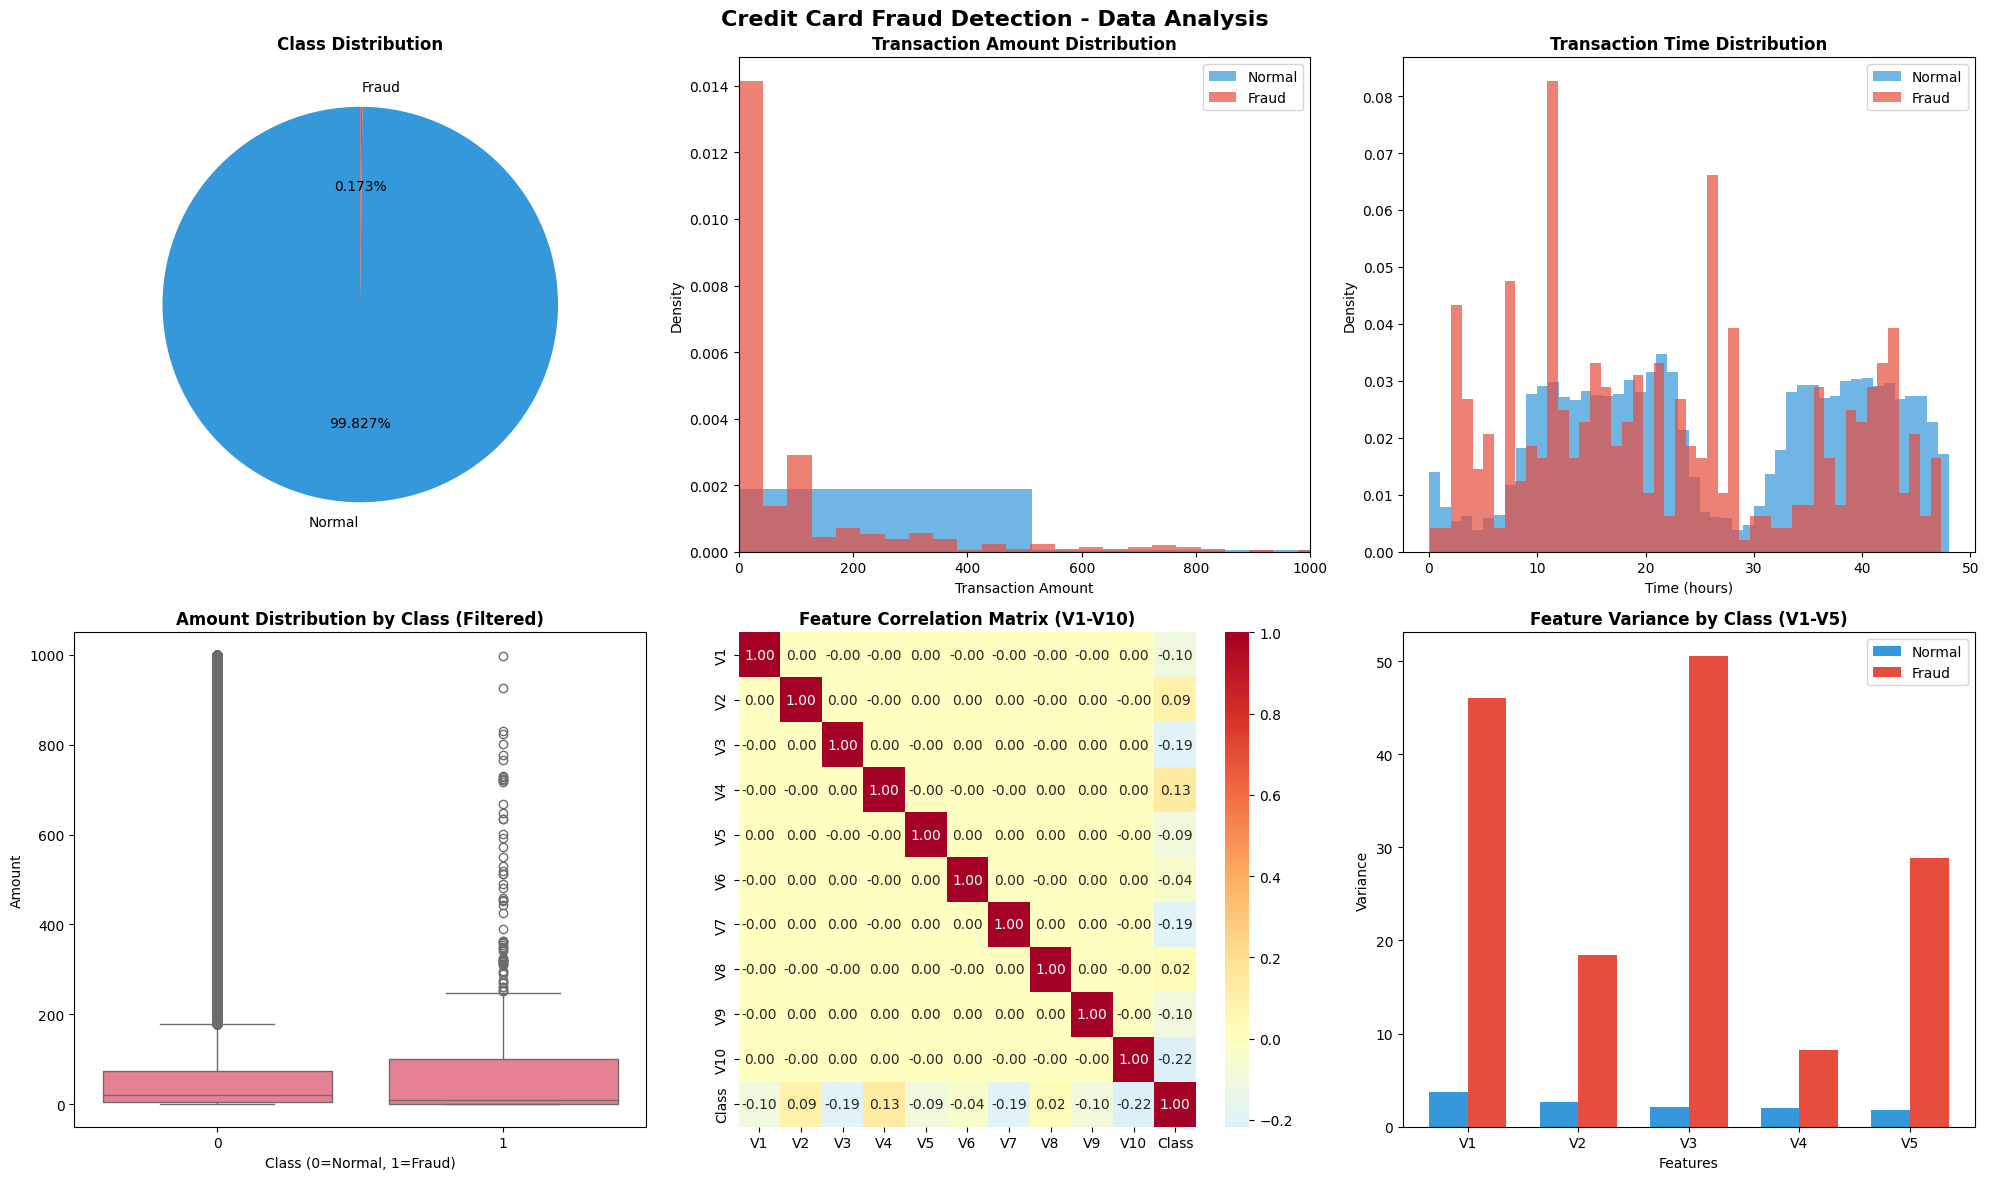


 FEATURE PREPARATION:
Features selected: 31
Feature names: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9']...

 DATA SPLIT:
Training set: 227,845 samples
Test set: 56,962 samples

  HANDLING CLASS IMBALANCE
Original distribution: Normal=227,451, Fraud=394
 Applying SMOTE (Synthetic Minority Oversampling)...
New distribution: Normal=227,451, Fraud=22,745
Fraud ratio: 0.091

 TRAINING LOGISTIC REGRESSION MODEL
 Scaling features...
 Training model...

🏆 TOP 15 MOST IMPORTANT FEATURES:
feature  coefficient
    V14    -3.228912
    V10    -2.200533
    V17    -2.128528
    V12    -1.832968
     V4     1.792921
     V1     1.717913
     V7    -1.230438
    V16    -1.195295
     V5     1.167143
 Amount     1.156865
     V8    -0.887648
    V11     0.681568
     V9    -0.678247
    V13    -0.600170
     V2     0.582201

 Training accuracy: 0.9925

 MODEL EVALUATION
 ROC-AUC Score: 0.9740
 Average Precision Score: 0.7179

 CLASSIFICATION REPORT:
              precision    recall

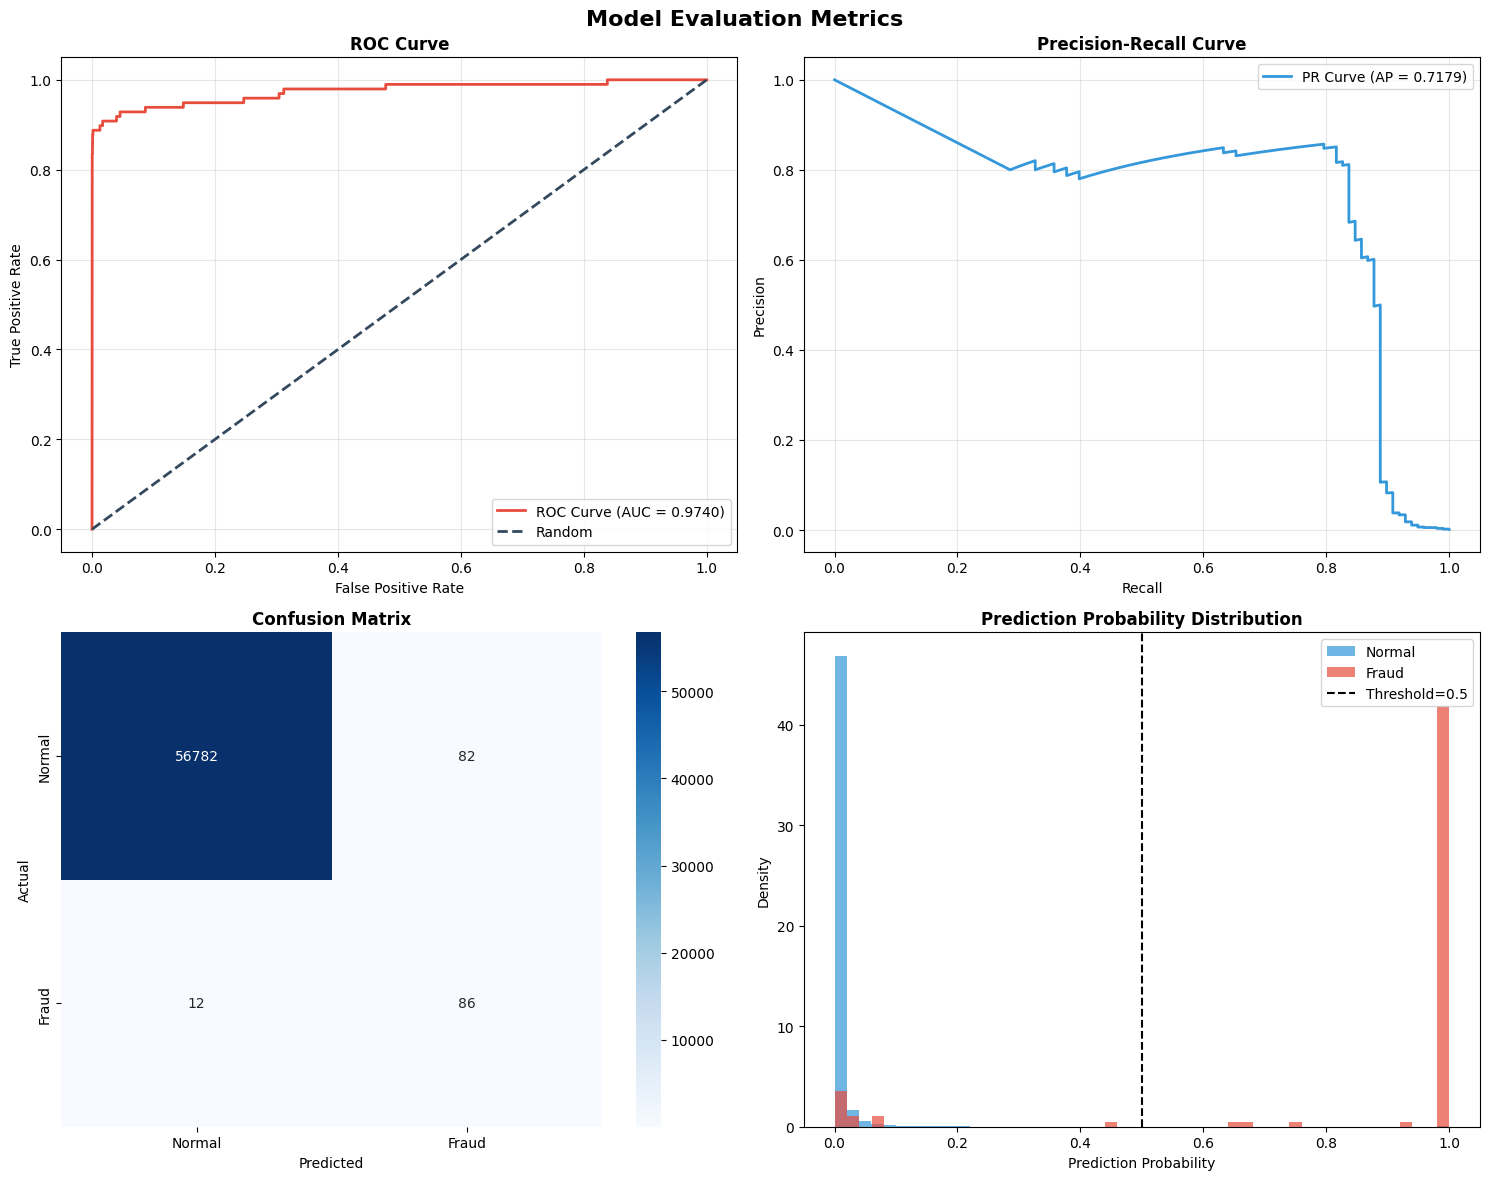


 REAL-TIME FRAUD DETECTION SIMULATION
 Processing 1000 transactions...

 REAL-TIME DETECTION RESULTS:
Total transactions: 1,000
Fraud alerts: 2
Actual fraud cases: 2
Alert rate: 0.20%

 PERFORMANCE METRICS:
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000

 TOP 10 FRAUD ALERTS:
Transaction_ID  Fraud_Probability  Amount Actual_Class   Alert_Status
    TXN_251477           1.000000    0.77        FRAUD  True Positive
    TXN_000541           0.999997    0.00        FRAUD  True Positive

 PIPELINE COMPLETED SUCCESSFULLY!
 Final ROC-AUC Score: 0.9740
 Model ready for deployment!


In [ ]:
    from google.colab import drive
    drive.mount('/content/drive')
    detector, dataset, X_test, y_test, alerts = run_fraud_detection_pipeline('/content/drive/MyDrive/creditcard.csv')